In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from keras import models,layers
import matplotlib.pyplot as plt

In [3]:

#created variales for images size
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=1
EPOCHS=50

In [4]:
# added code to convert images to grayscale
def convert_to_grayscale(image, label):
    image = tf.image.rgb_to_grayscale(image)
    return image, label

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Original_RGB/original_RGB",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="int"
)

Found 2110 files belonging to 7 classes.


In [6]:
# apply the grayscale conversion to the dataset
dataset = dataset.map(convert_to_grayscale)

In [7]:
import os

data_dir = '/content/drive/MyDrive/Original_RGB/original_RGB'
class_names = sorted(os.listdir(data_dir))
print(class_names)

['Bacterial_Canker', 'Healthy  leaf', 'Healthy leaf', 'Sooty Mould  Leaf', 'Sooty Mould leaf', 'anthracnose  leaf', 'anthracnose leaf']


In [8]:
len(dataset)

66

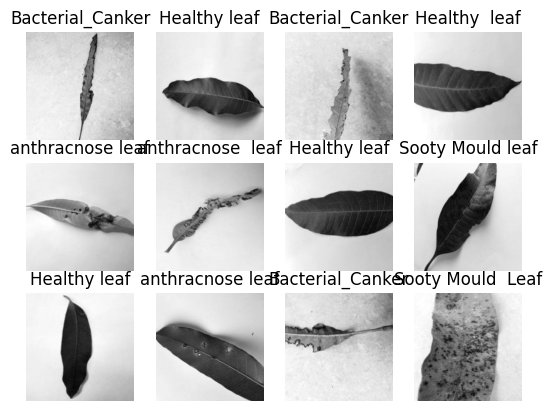

In [9]:
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"), cmap="gray")
        plt.title(class_names[label_batch[i]])
        # to turn off the axis points
        plt.axis("off")
        
        
    

In [10]:
#SPLITTING DATASET
#80 for training
# 20 for validation
#10 for tetsing
train_size=0.8
len(dataset)*train_size


52.800000000000004

In [11]:
train_ds=dataset.take(54)
len(train_ds)

54

In [12]:
test_ds=dataset.skip(54)
len(test_ds)

12

In [13]:
val_size=0.1
len(dataset)*val_size

6.6000000000000005

In [14]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds=test_ds.skip(6)
len(test_ds)

6

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

52

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [22]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(
        IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])

In [23]:
# Data Augmentation
# Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(
        "horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
# Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 7


model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)


In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 1)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (32, 127, 127, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
52/52 [==============================] - 179s 217ms/step - loss: 2.0017 - accuracy: 0.1929 - val_loss: 1.9378 - val_accuracy: 0.1406
Epoch 2/25
52/52 [==============================] - 7s 128ms/step - loss: 1.7665 - accuracy: 0.3023 - val_loss: 1.5927 - val_accuracy: 0.3906
Epoch 3/25
52/52 [==============================] - 8s 157ms/step - loss: 1.5342 - accuracy: 0.3636 - val_loss: 1.5034 - val_accuracy: 0.4271
Epoch 4/25
52/52 [==============================] - 6s 122ms/step - loss: 1.4385 - accuracy: 0.4008 - val_loss: 1.5958 - val_accuracy: 0.3646
Epoch 5/25
52/52 [==============================] - 6s 123ms/step - loss: 1.4014 - accuracy: 0.4219 - val_loss: 1.6473 - val_accuracy: 0.2969
Epoch 6/25
52/52 [==============================] - 8s 146ms/step - loss: 1.3672 - accuracy: 0.4285 - val_loss: 1.4942 - val_accuracy: 0.4323
Epoch 7/25
52/52 [==============================] - 7s 142ms/step - loss: 1.3374 - accuracy: 0.4399 - val_loss: 1.4125 - val_accuracy: 0.4688
Epoc

In [29]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 22ms/step - loss: 0.9112 - accuracy: 0.6289


In [30]:
scores

[0.9112250208854675, 0.62890625]

In [31]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 52}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
type(history.history['loss'])

list

In [34]:
len(history.history['loss'])

25

In [35]:
history.history['loss'][:5] # show loss for first 5 epochs


[2.0016872882843018,
 1.766491413116455,
 1.5342339277267456,
 1.4384949207305908,
 1.401384949684143]

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

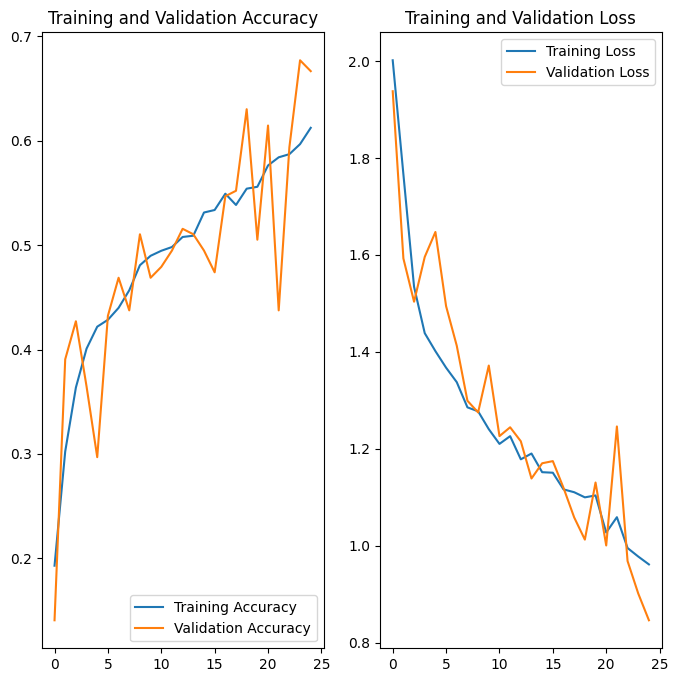

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(25), acc, label='Training Accuracy')
plt.plot(range(25), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(25), loss, label='Training Loss')
plt.plot(range(25), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
model.save("/content/drive/MyDrive/Original_RGB/models/og2new.h5")

first image to predict
actual label: Healthy leaf
1/1 [==============================] - 0s 123ms/step
predicted label: Healthy leaf


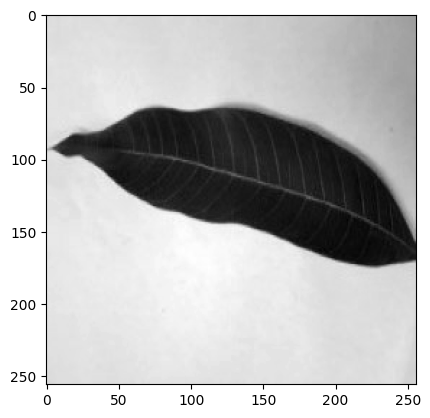

In [39]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image, cmap="gray")
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


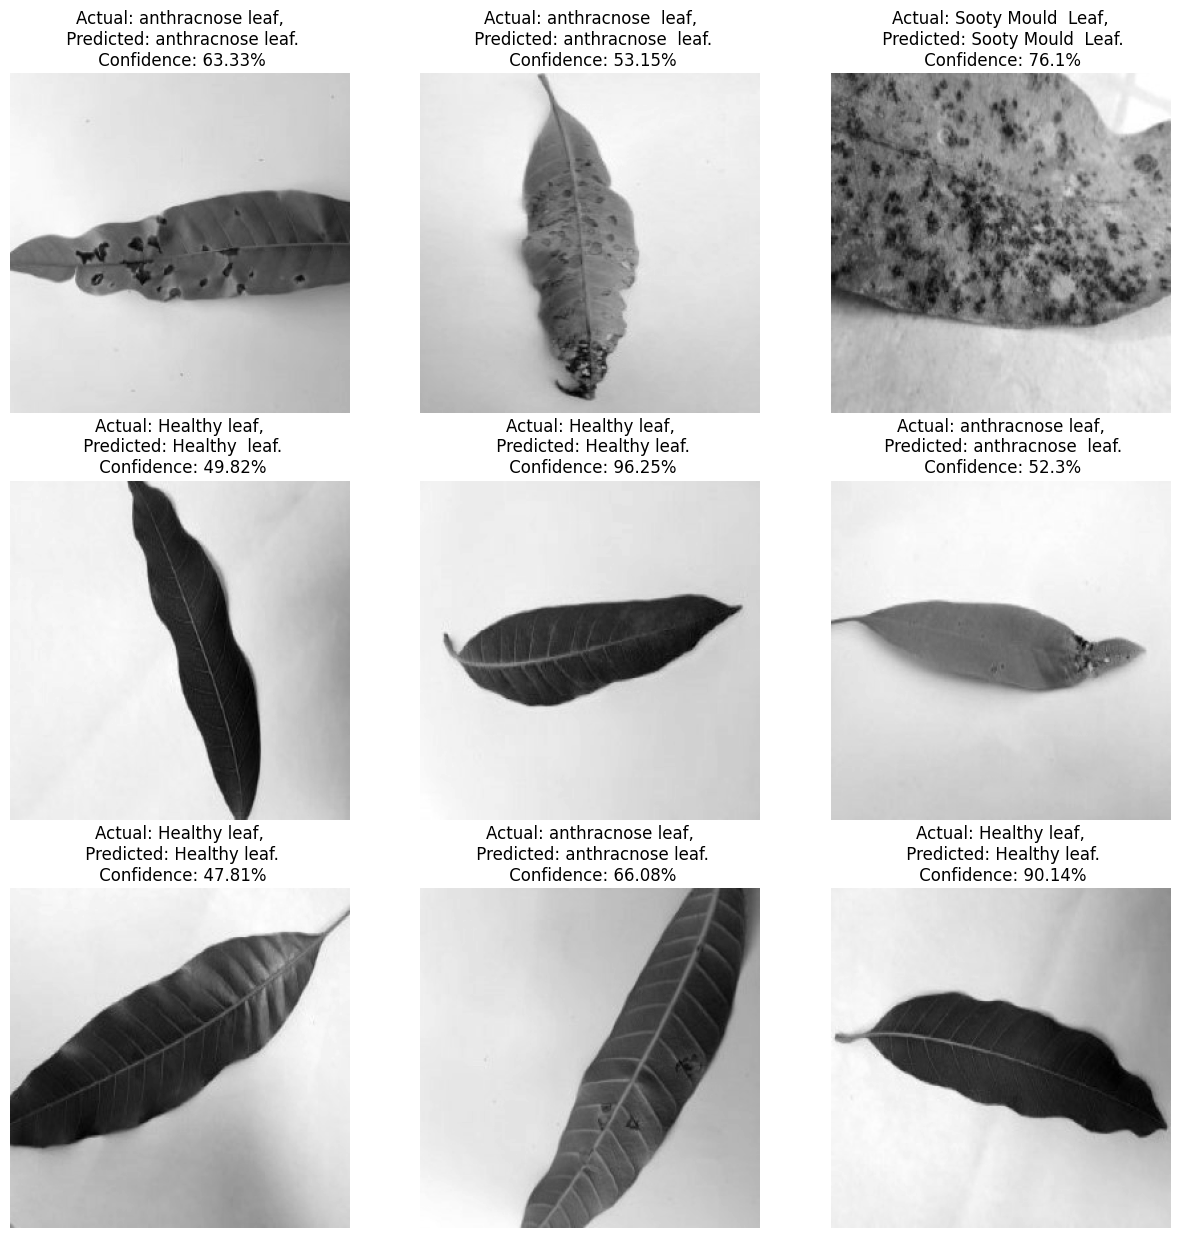

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")